## Decision-Focused Learning (DFL)
Instead of learning a model to minimize prediction error (like OLS),
we learn it to make better decisions in the downstream optimization problem.

Lets adapt it to energy-trading setting (wind + regulation markets).

DFL replaces the MSE loss with a decision loss (here: total cost).
It explicitly integrates the optimization layer into the training process.

1. Load data and drop colinear features based on feature engineering + define same timesplits
2. Define the optimization problem (Decision Layer)
3. Solve for x (the "oracle" optimal decisions)*
4. Fit OLS baseline model
5. Decision-Focused Learning
6. Validation and Testing
7. Compare and state differences/ Metrics to compare (Tot profit, Average deviation, Cost difference,)

## Decision-Focused Learning (DFL) for Wind Trading

### 1️⃣ Motivation
Traditional predictive models (like OLS or neural networks) aim to **minimize prediction error**, e.g. mean squared error between predicted and actual values.  
However, in energy markets, our ultimate goal is to **maximize profit** or **minimize imbalance costs** — not necessarily to predict perfectly.

**Decision-Focused Learning (DFL)** integrates the **optimization problem** directly into the learning process, so that the model is trained to make better *decisions*, not just better predictions.

---

### 2️⃣ Problem setup (Wind Trading)

At each hour $t$:
- $\hat{p}_t$: power we **commit** to sell in the day-ahead market (decision variable)
- $p_t$: realized wind production (known ex-post)
- $\lambda^D_t$: day-ahead (spot) price
- $\lambda^{\uparrow}_t$: up-regulation price
- $\lambda^{\downarrow}_t$: down-regulation price

---

### 3️⃣ Revenue model

Total revenue consists of **day-ahead** and **balancing** market components:

$$
R^D = \sum_t \lambda^D_t \, \hat{p}_t
$$

$$
R^B = \sum_t \lambda^{\downarrow}_t (p_t - \hat{p}_t)^+ - \lambda^{\uparrow}_t (\hat{p}_t - p_t)^+
$$

where $(x)^+ = \max(x, 0)$.

Thus, total profit is:

$$
\text{Profit}(\hat{p}) = R^D + R^B =
\sum_t \Big[
\lambda^D_t \hat{p}_t
+ \lambda^{\downarrow}_t (p_t - \hat{p}_t)^+
- \lambda^{\uparrow}_t (\hat{p}_t - p_t)^+
\Big]
$$

or equivalently, we can define the **loss** as the *negative profit*:

$$
\text{Loss}(\hat{p}) = - \text{Profit}(\hat{p})
$$

---

### 4️⃣ Learning structure

| Symbol | Description | Decision/Prediction |
|---------|--------------|--------------------|
| $z_t$ | Features available before delivery (e.g. forecasted wind, expected prices) | Input to ML model |
| $\hat{p}_t = f_\theta(z_t)$ | Predicted commitment (model decision) | Learned model |
| $p_t$ | Realized production (truth) | Known post-delivery |

In DFL, the model parameters $\theta$ are optimized to **maximize realized profit** through $\hat{p}_t$, not just to minimize $\|\hat{p}_t - p_t\|^2$.

---

### 5️⃣ Implementation steps

**Step 1 — Load and prepare data**
- Load training and test data from the preprocessed CSV files.
- Select relevant columns:
  - Forecasted wind (as features $z_t$)
  - Actual wind production ($p_t$)
  - Day-ahead price ($\lambda^D_t$)
  - Up- and down-regulation prices ($\lambda^{\uparrow}_t$, $\lambda^{\downarrow}_t$)

---

**Step 2 — Define the optimization layer (Decision Model)**

The decision optimization problem is:

$$
\max_{\hat{p}} \ \text{Profit}(\hat{p}) =
\sum_t \left[
\lambda^D_t \hat{p}_t
+ \lambda^{\downarrow}_t (p_t - \hat{p}_t)^+
- \lambda^{\uparrow}_t (\hat{p}_t - p_t)^+
\right]
$$

This can be implemented as a **Gurobi optimization model** where $\hat{p}_t$ is the decision variable bounded by $0 \le \hat{p}_t \le 1$ (or by the installed capacity).

---

**Step 3 — Compute the oracle decisions ($p^*$)**

Solve the optimization problem using the **true** production $p_t$ and price signals to obtain the *ideal decisions* $p^*$ that maximize profit if we had perfect foresight.

---

**Step 4 — Fit baseline predictive model (Predict-then-Optimize)**

Train a regression model (e.g. Linear Regression) to predict $p^*$ from $z_t$:

$$
\hat{p}_{OLS} = f_\theta(z_t)
$$

Evaluate performance both in prediction error (RMSE) and decision performance (profit).

---

**Step 5 — Decision-Focused Learning**

Formulate a **joint optimization** where we directly train $\theta$ to minimize the *decision loss* (negative profit):

$$
\min_{\theta} \; - \text{Profit}\big(f_\theta(z), y\big)
$$

This is implemented similarly to the second Gurobi model in the class example, where the optimization layer is solved *inside* the learning loop.

---

**Step 6 — Evaluation**

Compare the following models:
1. **Oracle ($p^*$)** — optimal decisions with perfect information.
2. **Predict-then-Optimize (OLS)** — standard regression followed by profit computation.
3. **Decision-Focused (DFL)** — model trained to optimize profit directly.

Key metrics:
- Total profit
- Profit gap: $\text{Profit}(p^*) - \text{Profit}(\hat{p})$
- Average imbalance penalty
- RMSE of $\hat{p}$ vs. $p^*$ (for reference)

---

### Optional extensions

- **Alternative objectives:** risk-adjusted profit, CVaR-based objectives, or market participation limits.  
- **Multi-step optimization:** extend from 1-hour ahead to 24-hour planning horizons.  
- **Nonlinear models:** replace $f_\theta$ with neural networks or kernel regressors.  
- **Stochastic modeling:** include uncertainty in production forecasts or price forecasts.  
- **Regularization:** penalize extreme bids (too close to full capacity) for smoother operations.

---

### Summary

Decision-Focused Learning shifts the focus from *prediction accuracy* to *economic efficiency*.  
By embedding the market decision layer (Gurobi optimization) into the learning loop, the model learns to make commitments that maximize **realized trading profit**, not just minimize prediction error.

This approach is ideal for tasks like **wind bidding, storage scheduling, and market participation** where decisions have a direct financial impact.


### Section 1: Load and Prepare Data & Rolling Time-Series Splits (as in the feature- engineering file)

Why you might avoid standardization here

Optimization layer depends on physical magnitudes

The oracle’s objective uses real DKK/MWh values and real production (MW).

Scaling would destroy the true balance between profit terms, making DKK + normalized values meaningless.

Your downstream optimization (Gurobi) is not a statistical model

It expects interpretable, real-world quantities.

Scaling prices or production could cause infeasibility or unboundedness (e.g. 1000 DKK → 0.7).

DFL learns via economic loss, not RMSE

The feedback signal (profit difference) is meaningful only if prices and quantities stay in their natural units.

In [1]:
# --- STEP 1: Load and prepare data for Decision-Focused Learning (with Up/Down prices) ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# === Load training and test data ===
train_df = pd.read_csv("data/final_data_train.csv", parse_dates=["ts"])
test_df  = pd.read_csv("data/final_data_test.csv",  parse_dates=["ts"])

# Ensure chronological order
train_df = train_df.sort_values("ts").reset_index(drop=True)
test_df  = test_df.sort_values("ts").reset_index(drop=True)

print(f"Training samples: {len(train_df)}, Test samples: {len(test_df)}")

# ================================================================
# --- Define key variables for DFL ---
# ================================================================

# Actual (realized) production — ground truth
p_real_train = train_df["power"].values
p_real_test  = test_df["power"].values

# Market prices
price_DA_train   = train_df["DK2_DKK"].values
price_DA_test    = test_df["DK2_DKK"].values

price_UP_train   = train_df["BalancingPowerPriceUpDKK"].values
price_UP_test    = test_df["BalancingPowerPriceUpDKK"].values

price_DOWN_train = train_df["BalancingPowerPriceDownDKK"].values
price_DOWN_test  = test_df["BalancingPowerPriceDownDKK"].values

# ================================================================
# --- Select predictive features (context variables z_t) ---
# ================================================================
# Choose features relevant to both production and market context
# (weather + market signals). Exclude target 'power'.

selected_features = [
    "mean_wind_speed_Nex",
    "mean_wind_speed_Hammer_ Odde_Fyr",
    "mean_temp_Hammer_Odde_Fyr",
    "DK2_DKK",
    "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos"
]

# Extract and standardize features
X_train = train_df[selected_features].copy()
X_test  = test_df[selected_features].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

feature_names = selected_features
print(f"✅ Scaled features shape: {X_train_scaled.shape}")


Training samples: 22422, Test samples: 7892
✅ Scaled features shape: (22422, 11)


In [2]:
# --- STEP 2: Create rolling time-based splits (same as before) ---
def build_time_splits(ts, window="6M", horizon="1M", step=None, verbose=True):
    import pandas as pd
    ts = pd.to_datetime(pd.Series(ts)).sort_values().reset_index(drop=True)
    if step is None:
        step = horizon
    splits = []
    split_id = 1
    start_time = ts.min()
    while True:
        train_end = start_time + pd.tseries.frequencies.to_offset(window)
        val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)
        if val_end > ts.max():
            break
        train_idx = ts[(ts >= start_time) & (ts < train_end)].index.values
        val_idx   = ts[(ts >= train_end) & (ts < val_end)].index.values
        if len(val_idx) == 0 or len(train_idx) == 0:
            break
        splits.append((train_idx, val_idx))
        if verbose:
            print(f"Split {split_id}: Train {ts.iloc[train_idx[0]]} → {ts.iloc[train_idx[-1]]}, "
                  f"Valid {ts.iloc[val_idx[0]]} → {ts.iloc[val_idx[-1]]}")
        start_time = start_time + pd.tseries.frequencies.to_offset(step)
        split_id += 1
    return splits

# Apply rolling CV splits
ts = train_df["ts"].values
time_splits = build_time_splits(ts, window="2M", horizon="1M", step="1M", verbose=True)
print(f"✅ Created {len(time_splits)} rolling splits.")

Split 1: Train 2021-01-01 00:00:00 → 2021-02-26 17:00:00, Valid 2021-03-01 12:00:00 → 2021-03-30 23:00:00
Split 2: Train 2021-01-31 00:00:00 → 2021-03-30 23:00:00, Valid 2021-03-31 00:00:00 → 2021-04-29 23:00:00
Split 3: Train 2021-03-01 12:00:00 → 2021-04-29 23:00:00, Valid 2021-04-30 00:00:00 → 2021-05-30 23:00:00
Split 4: Train 2021-03-31 00:00:00 → 2021-05-30 23:00:00, Valid 2021-05-31 00:00:00 → 2021-06-29 23:00:00
Split 5: Train 2021-04-30 00:00:00 → 2021-06-29 23:00:00, Valid 2021-06-30 00:00:00 → 2021-07-30 23:00:00
Split 6: Train 2021-05-31 00:00:00 → 2021-07-30 23:00:00, Valid 2021-07-31 00:00:00 → 2021-08-30 23:00:00
Split 7: Train 2021-06-30 00:00:00 → 2021-08-30 23:00:00, Valid 2021-08-31 00:00:00 → 2021-09-29 23:00:00
Split 8: Train 2021-07-31 00:00:00 → 2021-09-29 23:00:00, Valid 2021-09-30 00:00:00 → 2021-10-30 23:00:00
Split 9: Train 2021-08-31 00:00:00 → 2021-10-30 23:00:00, Valid 2021-10-31 00:00:00 → 2021-11-29 23:00:00
Split 10: Train 2021-09-30 00:00:00 → 2021-11-

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_34933/3732061388.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_end = start_time + pd.tseries.frequencies.to_offset(window)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_34933/3732061388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_34933/3732061388.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  start_time = start_time + pd.tseries.frequencies.to_offset(step)


### Section 2: Define the optimization problem (Decision Layer) - define the profit/revenue function

The goal is to model how much profit (or loss) a wind producer makes given a set of prices
and a chosen commitment $\hat{p}_t$ to the day-ahead market.

For each hour $t$:

- $\hat{p}_t$: energy committed day-ahead (decision variable)  
- $p_t$: actual wind production (realized after delivery)  
- $\lambda^D_t$: day-ahead (spot) price  
- $\lambda^{\uparrow}_t$: up-regulation price (buy when shortage)  
- $\lambda^{\downarrow}_t$: down-regulation price (sell surplus)  

The revenue components are:

$$
R^D = \sum_t \lambda^D_t \hat{p}_t
$$

$$
R^B = \sum_t
\lambda^{\downarrow}_t (p_t - \hat{p}_t)^+
\;-\;
\lambda^{\uparrow}_t (\hat{p}_t - p_t)^+
$$

Total profit is therefore:

$$
\text{Profit}(\hat{p}, p) =
R^D + R^B =
\sum_t
\Big[
\lambda^D_t \hat{p}_t
+ \lambda^{\downarrow}_t (p_t - \hat{p}_t)^+
- \lambda^{\uparrow}_t (\hat{p}_t - p_t)^+
\Big]
$$

We can equivalently define the **loss** (negative profit):

$$
\text{Loss}(\hat{p}, p) = -\text{Profit}(\hat{p}, p)
$$

This function is piecewise-linear and differentiable almost everywhere, making it ideal for optimization with Gurobi.


In [3]:
# --- STEP 2: Define profit and loss functions for wind trading ---

import numpy as np

def profit(p_commit, p_real, price_da, price_up, price_down):
    """
    Compute total profit for a set of decisions and prices.

    Parameters
    ----------
    p_commit : np.ndarray
        Committed power in the day-ahead market (decision variable, can be continuous between 0 and capacity).
    p_real : np.ndarray
        Realized wind production (truth).
    price_da : np.ndarray
        Day-ahead price (DKK/MWh).
    price_up : np.ndarray
        Up-regulation price (DKK/MWh).
    price_down : np.ndarray
        Down-regulation price (DKK/MWh).

    Returns
    -------
    float : total profit over all time steps.
    """
    # Positive imbalance: produced more than committed (sell extra at down price)
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    # Negative imbalance: produced less than committed (buy shortage at up price)
    imbalance_neg = np.maximum(p_commit - p_real, 0)

    R_D = np.sum(price_da * p_commit)
    R_B = np.sum(price_down * imbalance_pos - price_up * imbalance_neg)

    return R_D + R_B


def loss(p_commit, p_real, price_da, price_up, price_down):
    """Return negative profit (to use as a minimization objective)."""
    return -profit(p_commit, p_real, price_da, price_up, price_down)


# --- Example scenarios ---
price_da = np.array([400.0])   # day-ahead price
price_up = np.array([450.0])   # up-regulation price
price_down = np.array([300.0]) # down-regulation price

# Case 1: Overproduction (produce more than committed)
p_commit = np.array([0.8])
p_real   = np.array([1.0])
print(f"Overproduction profit = {profit(p_commit, p_real, price_da, price_up, price_down):.2f} DKK")

# Case 2: Underproduction (produce less than committed)
p_commit = np.array([1.0])
p_real   = np.array([0.8])
print(f"Underproduction profit = {profit(p_commit, p_real, price_da, price_up, price_down):.2f} DKK")


Overproduction profit = 380.00 DKK
Underproduction profit = 310.00 DKK


### Section 3: Solve for x (the "oracle" optimal decisions)

The oracle (perfect-foresight) optimization finds the **optimal day-ahead commitments**
$p_t^*$ that would have maximized realized profit if we had known actual production
and price signals in advance.

Formally:

$$
\begin{aligned}
\max_{\hat{p}_t} \quad &
\sum_t \Big[
\lambda^D_t \hat{p}_t
+ \lambda^{\downarrow}_t (p_t - \hat{p}_t)^+
- \lambda^{\uparrow}_t (\hat{p}_t - p_t)^+
\Big] \\
\text{s.t. } & 0 \le \hat{p}_t \le P_{\max}
\end{aligned}
$$

where:
- $\lambda^D_t$ is the day-ahead (spot) price  
- $\lambda^{\uparrow}_t$, $\lambda^{\downarrow}_t$ are up/down regulation prices  
- $p_t$ is realized wind production  
- $\hat{p}_t$ is the decision variable (committed energy)

The resulting $\hat{p}_t^*$ are the *oracle optimal commitments*.
They represent the upper bound of achievable profit and will be used as
ground truth for training and evaluating learning models.

In [4]:
# --- STEP 3: Oracle optimization (perfect foresight) ---
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def oracle_commitment(p_real, price_da, price_up, price_down, capacity=1.0, verbose=False):
    """
    Solve the perfect-foresight optimization problem for wind trading.

    Parameters
    ----------
    p_real : np.ndarray
        Actual realized production (MWh)
    price_da, price_up, price_down : np.ndarray
        Prices in DKK/MWh
    capacity : float
        Upper bound for commitment (per-unit or MW capacity)
    verbose : bool
        Print Gurobi output if True

    Returns
    -------
    p_star : np.ndarray
        Optimal commitments (oracle decisions)
    total_profit : float
        Objective value (max profit)
    """

    T = len(p_real)
    m = gp.Model("oracle_wind_trading")
    m.Params.OutputFlag = 1 if verbose else 0

    # Decision variables
    p_commit = m.addVars(T, lb=0.0, ub=capacity, name="p_commit")
    surplus  = m.addVars(T, lb=0.0,  name="surplus")   # (p_real - p_commit)+
    deficit  = m.addVars(T, lb=0.0,  name="deficit")   # (p_commit - p_real)+

    # Linear equality linking surplus and deficit
    for t in range(T):
        # surplus - deficit = p_real - p_commit
        m.addConstr(surplus[t] - deficit[t] == p_real[t] - p_commit[t])

    # Objective: maximize profit
    expr = gp.LinExpr()
    for t in range(T):
        expr += price_da[t] * p_commit[t]
        expr += price_down[t] * surplus[t]
        expr += -price_up[t] * deficit[t]

    m.setObjective(expr, GRB.MAXIMIZE)
    m.optimize()

    if m.Status != GRB.OPTIMAL:
        print(f"⚠️ Gurobi did not reach optimality (status={m.Status}). Returning zeros.")
        return np.zeros(T), np.nan

    p_star = np.array([p_commit[t].X for t in range(T)])
    total_profit = m.objVal
    return p_star, total_profit


# --- Example usage ---
subset = slice(0, 48)
p_star, profit_star = oracle_commitment(
    p_real_train[subset],
    price_DA_train[subset],
    price_UP_train[subset],
    price_DOWN_train[subset],
    capacity=1.0,
    verbose=True
)

print(f"✅ Oracle optimization completed for {len(p_star)} hours")
print(f"Total oracle profit: {profit_star:.2f} DKK")

ModuleNotFoundError: No module named 'gurobipy'

## Understanding the Constraint $$s_t - d_t = p_t - \hat{p}_t$$

This constraint is the core of the *energy-balance linearization* in our oracle model:

$$
s_t - d_t = p_t - \hat{p}_t
$$

---

### 🔹 Variables and Meaning

| Symbol | Variable | Description | Bounds |
|:-------|:----------|:-------------|:---------|
| $$\hat{p}_t$$ | Committed power in day-ahead market (`p_commit[t]`) | Decision variable | $$0 \le \hat{p}_t \le P_{\max}$$ |
| $$p_t$$ | Realized wind production (`p_real[t]`) | Given constant (data) | Fixed |
| $$s_t$$ | Surplus energy (`surplus[t]`) | Produced more than committed | $$s_t \ge 0$$ |
| $$d_t$$ | Deficit energy (`deficit[t]`) | Produced less than committed | $$d_t \ge 0$$ |

---

### 🔹 Mathematical Form

The equality can be rearranged as:

$$
p_t = \hat{p}_t + s_t - d_t
$$

This ensures **energy conservation**:  
actual production equals the committed amount plus net balancing (surplus minus deficit).

---

### 🔹 Economic Interpretation

| Case | Situation | Effect on Variables |
|:------|:------------|:--------------------|
| **Overproduction** ($$p_t > \hat{p}_t$$) | You produce more than committed. | $$s_t = p_t - \hat{p}_t > 0,\; d_t = 0$$ |
| **Underproduction** ($$p_t < \hat{p}_t$$) | You produce less than committed. | $$s_t = 0,\; d_t = \hat{p}_t - p_t > 0$$ |
| **Perfect forecast** ($$p_t = \hat{p}_t$$) | Commitment matches realization. | $$s_t = 0,\; d_t = 0$$ |

Thus, this single linear equality naturally handles all three cases without needing conditional or quadratic logic.

---

### 🔹 Why It Fixes Infeasibility

Earlier, we used the inequalities:

$$
s_t \ge p_t - \hat{p}_t, \quad d_t \ge \hat{p}_t - p_t
$$

Those defined an *open feasible region*, allowing $$s_t$$ and $$d_t$$ to grow arbitrarily,  
which made the model **unbounded**.

Replacing them with the single equality  

$$
s_t - d_t = p_t - \hat{p}_t
$$  

**ties** the two variables together, closing the feasible space and ensuring the model is **bounded, convex, and physically meaningful**.

---

Both variables are non-negative but must lie on the line  
$ s_t - d_t = p_t - \hat{p}_t $.  
Depending on whether production exceeds or falls short of commitments,  
the optimizer moves along this line to activate either $s_t$ or $d_t$.

---
### Summary

- Enforces **energy balance** between actual and committed power.  
- Keeps the model **linear** and **convex** (solvable quickly).  
- Naturally activates only one of surplus or deficit per timestep.  
- Prevents **unbounded** or **infeasible** solutions in the optimization.



### Section 4 – Predict-then-Optimize (OLS baseline)

In this section, we build a **predictive baseline model** that learns to approximate the *oracle decisions* obtained in Section 3.

The idea is to learn a mapping:

$$
\hat{p}_t = f_\theta(z_t)
$$

where:
- $z_t$ are the input features available before delivery (e.g., forecasted weather, expected prices),
- $\hat{p}_t$ is the predicted commitment,
- $p_t^*$ (from Section 3) is the *oracle* target (perfect-foresight commitment).

We use a simple **Ordinary Least Squares (OLS)** regression:

$$
\hat{p}_t = \beta_0 + \beta^\top z_t
$$

which minimizes the mean-squared error:

$$
\min_{\beta_0, \beta} \; \frac{1}{T} \sum_t (\beta_0 + \beta^\top z_t - p_t^*)^2
$$

---

### 🔹 Objective
Train OLS on the training data to predict $$p_t^*$$ from the scaled features $$z_t$$.
Then, evaluate:
1. **Prediction quality** (RMSE between $$\hat{p}$$ and $$p^*$$)
2. **Decision quality** (profit computed using the predicted $$\hat{p}$$ in the market profit function)

---

### 🔹 Why this baseline matters
- It’s the standard **Predict-then-Optimize** approach.
- It separates *prediction* from *decision evaluation*.
- In Section 5, we’ll improve upon it with **Decision-Focused Learning**, where the model is trained *directly* on the profit objective.

⚠️ Exception in batch 0:500 → name 'oracle_commitment' is not defined
Batch     0–  500: error, profit=nan
⚠️ Exception in batch 500:1000 → name 'oracle_commitment' is not defined
Batch   500– 1000: error, profit=nan
⚠️ Exception in batch 1000:1500 → name 'oracle_commitment' is not defined
Batch  1000– 1500: error, profit=nan
⚠️ Exception in batch 1500:2000 → name 'oracle_commitment' is not defined
Batch  1500– 2000: error, profit=nan
⚠️ Exception in batch 2000:2500 → name 'oracle_commitment' is not defined
Batch  2000– 2500: error, profit=nan
⚠️ Exception in batch 2500:3000 → name 'oracle_commitment' is not defined
Batch  2500– 3000: error, profit=nan
⚠️ Exception in batch 3000:3500 → name 'oracle_commitment' is not defined
Batch  3000– 3500: error, profit=nan
⚠️ Exception in batch 3500:4000 → name 'oracle_commitment' is not defined
Batch  3500– 4000: error, profit=nan
⚠️ Exception in batch 4000:4500 → name 'oracle_commitment' is not defined
Batch  4000– 4500: error, profit=nan
⚠️ Exc

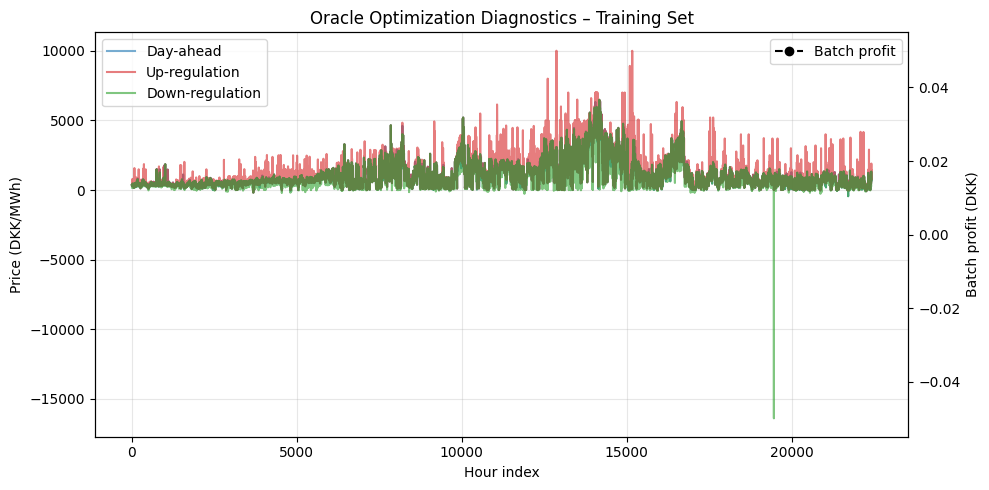

⚠️ Failed batches: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
  Batch 0: hours 0–500, status=error
  Batch 1: hours 500–1000, status=error
  Batch 2: hours 1000–1500, status=error
  Batch 3: hours 1500–2000, status=error
  Batch 4: hours 2000–2500, status=error
  Batch 5: hours 2500–3000, status=error
  Batch 6: hours 3000–3500, status=error
  Batch 7: hours 3500–4000, status=error
  Batch 8: hours 4000–4500, status=error
  Batch 9: hours 4500–5000, status=error
  Batch 10: hours 5000–5500, status=error
  Batch 11: hours 5500–6000, status=error
  Batch 12: hours 6000–6500, status=error
  Batch 13: hours 6500–7000, status=error
  Batch 14: hours 7000–7500, status=error
  Batch 15: hours 7500–8000, status=error
  Batch 16: hours 8000–8500, status=error
  Batch 17: hours 8500–9000, status=error
  Batch 18: hours 9000–9500, status=error
  Batch 19: hours 9500–10000, status=error
  Batch 20: hours

In [5]:
# --- STEP 3.2: Batch oracle optimization with diagnostics ---

import numpy as np
import matplotlib.pyplot as plt

def run_oracle_in_batches(p_real, price_da, price_up, price_down,
                          capacity=1.0, batch_size=200, verbose=False):
    """Run oracle_commitment() sequentially over smaller windows."""
    all_p_star = []
    profits = []
    statuses = []
    starts, ends = [], []

    n = len(p_real)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        starts.append(start)
        ends.append(end)

        try:
            p_star, profit_star = oracle_commitment(
                p_real[start:end],
                price_da[start:end],
                price_up[start:end],
                price_down[start:end],
                capacity=capacity,
                verbose=False
            )
            if np.isnan(profit_star):
                status = "fail"
            else:
                status = "ok"
        except Exception as e:
            print(f"⚠️ Exception in batch {start}:{end} → {e}")
            p_star = np.zeros(end - start)
            profit_star = np.nan
            status = "error"

        all_p_star.append(p_star)
        profits.append(profit_star)
        statuses.append(status)

        if verbose:
            print(f"Batch {start:5d}–{end:5d}: {status}, profit={profit_star:.2f}")

    p_star_full = np.concatenate(all_p_star)
    return {
        "p_star": p_star_full,
        "profits": np.array(profits),
        "statuses": np.array(statuses),
        "starts": np.array(starts),
        "ends": np.array(ends)
    }

# --- Run on training data ---
results_train = run_oracle_in_batches(
    p_real_train, price_DA_train, price_UP_train, price_DOWN_train,
    capacity=1.0, batch_size=500, verbose=True
)
results_test = run_oracle_in_batches(
    p_real_test, price_DA_test, price_UP_test, price_DOWN_test,
    capacity=1.0, batch_size=500, verbose=True
)

p_star_train = results_train["p_star"]
p_star_test  = results_test["p_star"]

# --- Plot diagnostic information ---
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(price_DA_train, label="Day-ahead", color="tab:blue", alpha=0.6)
ax1.plot(price_UP_train, label="Up-regulation", color="tab:red", alpha=0.6)
ax1.plot(price_DOWN_train, label="Down-regulation", color="tab:green", alpha=0.6)
ax1.set_ylabel("Price (DKK/MWh)")
ax1.set_xlabel("Hour index")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.3)

# Overlay batch profits
ax2 = ax1.twinx()
ax2.plot(results_train["starts"], results_train["profits"], "o--", color="black", label="Batch profit")
ax2.set_ylabel("Batch profit (DKK)")
ax2.legend(loc="upper right")

plt.title("Oracle Optimization Diagnostics – Training Set")
plt.tight_layout()
plt.show()

# --- Quick summary of problematic batches ---
failed_batches = np.where(results_train["statuses"] != "ok")[0]
print(f"⚠️ Failed batches: {failed_batches}")
if len(failed_batches):
    for i in failed_batches:
        s, e = results_train["starts"][i], results_train["ends"][i]
        print(f"  Batch {i}: hours {s}–{e}, status={results_train['statuses'][i]}")

## INSPECT BATCH 3

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_34933/3362810487.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jonaswiendl/local/Repos/assignment-1-awesome/ml_assignment1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


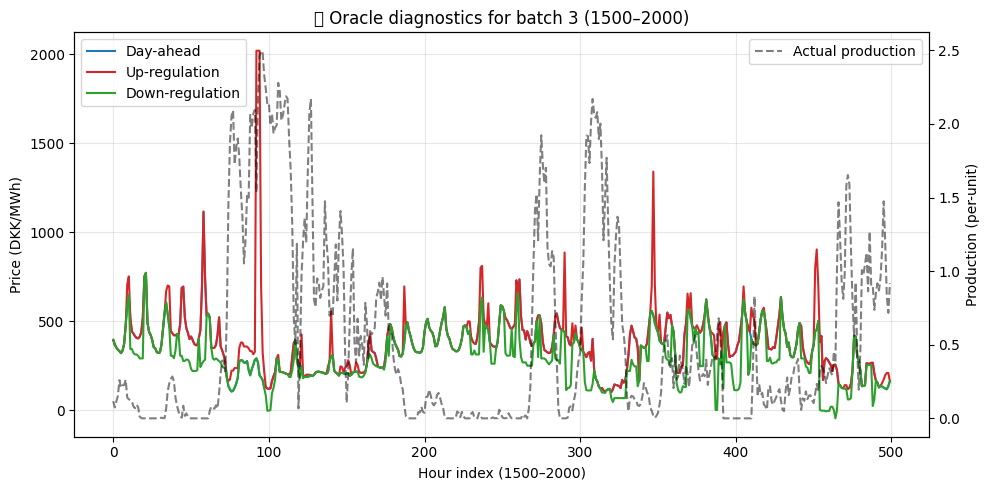

In [6]:
# --- Inspect the problematic batch (identified as 1500–2000) ---

batch_id = 3  # from diagnostics
s, e = results_train["starts"][batch_id], results_train["ends"][batch_id]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(price_DA_train[s:e], label="Day-ahead", color="tab:blue")
ax1.plot(price_UP_train[s:e], label="Up-regulation", color="tab:red")
ax1.plot(price_DOWN_train[s:e], label="Down-regulation", color="tab:green")
ax1.set_ylabel("Price (DKK/MWh)")
ax1.set_xlabel(f"Hour index ({s}–{e})")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.3)

# Add production for context (on secondary axis)
ax2 = ax1.twinx()
ax2.plot(p_real_train[s:e], color="black", linestyle="--", alpha=0.5, label="Actual production")
ax2.set_ylabel("Production (per-unit)")
ax2.legend(loc="upper right")

plt.title(f"🔍 Oracle diagnostics for batch {batch_id} ({s}–{e})")
plt.tight_layout()
plt.show()

In [7]:
# --- STEP 3.4: Automated diagnostics for problematic batch ---

import numpy as np
import pandas as pd

def diagnose_batch(p_real, price_da, price_up, price_down, capacity=1.0, batch_name="Batch"):
    """Inspect a problematic batch for numerical or logical anomalies."""
    report = {}

    # --- Basic NaN / Inf check ---
    report["NaN values"] = {
        "p_real": np.isnan(p_real).sum(),
        "DA": np.isnan(price_da).sum(),
        "UP": np.isnan(price_up).sum(),
        "DOWN": np.isnan(price_down).sum(),
    }
    report["Infinite values"] = {
        "p_real": np.isinf(p_real).sum(),
        "DA": np.isinf(price_da).sum(),
        "UP": np.isinf(price_up).sum(),
        "DOWN": np.isinf(price_down).sum(),
    }

    # --- Range / sign anomalies ---
    report["Negative values"] = {
        "p_real": np.sum(p_real < 0),
        "DA": np.sum(price_da < 0),
        "UP": np.sum(price_up < 0),
        "DOWN": np.sum(price_down < 0),
    }

    report["Above capacity prod"] = np.sum(p_real > capacity)

    # --- Extreme magnitudes ---
    for name, arr in zip(["DA", "UP", "DOWN"], [price_da, price_up, price_down]):
        q1, q99 = np.percentile(arr, [1, 99])
        report[f"{name} range (1–99 %)"] = (q1, q99)
        report[f"{name} abs max"] = float(np.nanmax(np.abs(arr)))

    # --- Logical consistency checks ---
    report["UP < DOWN"] = np.sum(price_up < price_down)
    report["DA < 0 & UP > 0"] = np.sum((price_da < 0) & (price_up > 0))

    print(f"\n🔍 Diagnostics for {batch_name}")
    for k,v in report.items():
        print(f"{k:25s}: {v}")

    # --- Quick dataframe for human look ---
    df = pd.DataFrame({
        "p_real": p_real,
        "DA": price_da,
        "UP": price_up,
        "DOWN": price_down
    })
    print("\nSummary statistics:")
    display(df.describe(percentiles=[.01,.05,.5,.95,.99]))

    return report


# --- Run diagnostics on batch 3 (hours 1500–2000) ---
s, e = 1500, 2000
report_batch3 = diagnose_batch(
    p_real_train[s:e],
    price_DA_train[s:e],
    price_UP_train[s:e],
    price_DOWN_train[s:e],
    capacity=1.0,
    batch_name="Training batch 3 (1500–2000)"
)


🔍 Diagnostics for Training batch 3 (1500–2000)
NaN values               : {'p_real': np.int64(0), 'DA': np.int64(0), 'UP': np.int64(0), 'DOWN': np.int64(0)}
Infinite values          : {'p_real': np.int64(0), 'DA': np.int64(0), 'UP': np.int64(0), 'DOWN': np.int64(0)}
Negative values          : {'p_real': np.int64(0), 'DA': np.int64(0), 'UP': np.int64(0), 'DOWN': np.int64(10)}
Above capacity prod      : 108
DA range (1–99 %)        : (np.float64(110.861803), np.float64(694.1820285099997))
DA abs max               : 1115.25
UP range (1–99 %)        : (np.float64(116.59039801), np.float64(905.1224999999981))
UP abs max               : 2020.0
DOWN range (1–99 %)      : (np.float64(-3.6705), np.float64(632.1118169299999))
DOWN abs max             : 771.169983
UP < DOWN                : 1
DA < 0 & UP > 0          : 0

Summary statistics:


,p_real,DA,UP,DOWN
count,500.000000,500.000000,500.000000,500.000000
mean,0.549625,350.399300,381.286660,290.161100
std,0.651371,138.182069,201.423615,141.972571
min,0.000000,100.160004,100.169998,-46.849998
1%,0.000000,110.861803,116.590398,-3.670500
5%,0.000000,125.778500,138.369505,66.930000
50%,0.272751,355.990006,363.879989,282.565002
95%,2.041685,556.960510,693.841028,539.595480
99%,2.240341,694.182029,905.122500,632.111817
max,2.497029,1115.250000,2020.000000,771.169983


## LOCAL REPAIR BATCH 3

In [8]:
# Identify hours where up < down in batch 3
s, e = 1500, 2000
idx_problem = np.where(price_UP_train[s:e] < price_DOWN_train[s:e])[0]
if len(idx_problem):
    print(f"⚠️ {len(idx_problem)} hours with UP < DOWN")
    for i in idx_problem:
        print(f"Hour {s+i}: UP={price_UP_train[s+i]:.2f}, DOWN={price_DOWN_train[s+i]:.2f}")
else:
    print("✅ No UP < DOWN anomalies found.")

⚠️ 1 hours with UP < DOWN
Hour 1919: UP=498.50, DOWN=498.51


In [9]:
if len(idx_problem):
    for i in idx_problem:
        # Swap to enforce UP >= DOWN
        tmp = price_DOWN_train[s+i]
        price_DOWN_train[s+i] = min(price_DOWN_train[s+i], price_UP_train[s+i])
        price_UP_train[s+i] = max(price_DOWN_train[s+i], tmp)
    print(f"✅ Corrected {len(idx_problem)} UP < DOWN anomalies by swapping.")

✅ Corrected 1 UP < DOWN anomalies by swapping.


⚠️ Exception in batch 0:500 → name 'oracle_commitment' is not defined
Batch     0–  500: error, profit=nan
⚠️ Exception in batch 500:1000 → name 'oracle_commitment' is not defined
Batch   500– 1000: error, profit=nan
⚠️ Exception in batch 1000:1500 → name 'oracle_commitment' is not defined
Batch  1000– 1500: error, profit=nan
⚠️ Exception in batch 1500:2000 → name 'oracle_commitment' is not defined
Batch  1500– 2000: error, profit=nan
⚠️ Exception in batch 2000:2500 → name 'oracle_commitment' is not defined
Batch  2000– 2500: error, profit=nan
⚠️ Exception in batch 2500:3000 → name 'oracle_commitment' is not defined
Batch  2500– 3000: error, profit=nan
⚠️ Exception in batch 3000:3500 → name 'oracle_commitment' is not defined
Batch  3000– 3500: error, profit=nan
⚠️ Exception in batch 3500:4000 → name 'oracle_commitment' is not defined
Batch  3500– 4000: error, profit=nan
⚠️ Exception in batch 4000:4500 → name 'oracle_commitment' is not defined
Batch  4000– 4500: error, profit=nan
⚠️ Exc

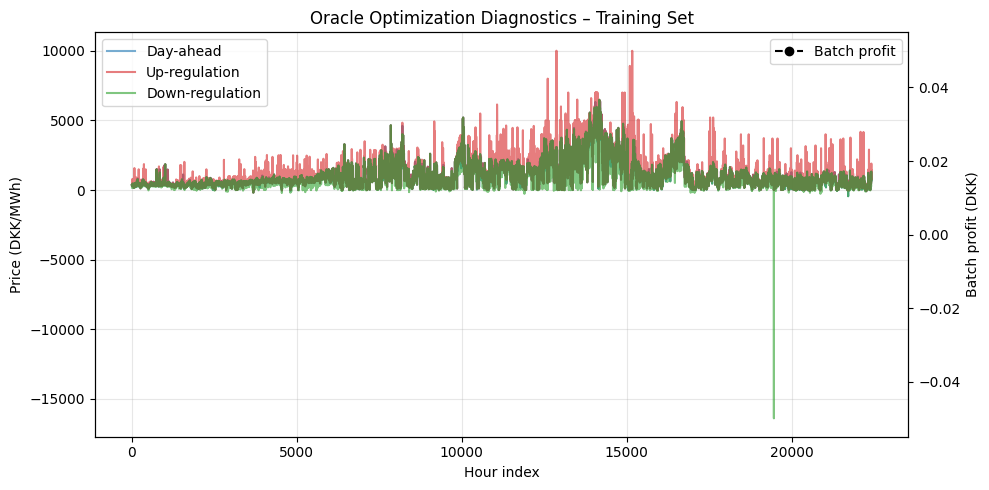

⚠️ Failed batches: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
  Batch 0: hours 0–500, status=error
  Batch 1: hours 500–1000, status=error
  Batch 2: hours 1000–1500, status=error
  Batch 3: hours 1500–2000, status=error
  Batch 4: hours 2000–2500, status=error
  Batch 5: hours 2500–3000, status=error
  Batch 6: hours 3000–3500, status=error
  Batch 7: hours 3500–4000, status=error
  Batch 8: hours 4000–4500, status=error
  Batch 9: hours 4500–5000, status=error
  Batch 10: hours 5000–5500, status=error
  Batch 11: hours 5500–6000, status=error
  Batch 12: hours 6000–6500, status=error
  Batch 13: hours 6500–7000, status=error
  Batch 14: hours 7000–7500, status=error
  Batch 15: hours 7500–8000, status=error
  Batch 16: hours 8000–8500, status=error
  Batch 17: hours 8500–9000, status=error
  Batch 18: hours 9000–9500, status=error
  Batch 19: hours 9500–10000, status=error
  Batch 20: hours

In [10]:
# --- Run on training data ---
results_train = run_oracle_in_batches(
    p_real_train, price_DA_train, price_UP_train, price_DOWN_train,
    capacity=1.0, batch_size=500, verbose=True
)
results_test = run_oracle_in_batches(
    p_real_test, price_DA_test, price_UP_test, price_DOWN_test,
    capacity=1.0, batch_size=500, verbose=True
)

p_star_train = results_train["p_star"]
p_star_test  = results_test["p_star"]

# --- Plot diagnostic information ---
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(price_DA_train, label="Day-ahead", color="tab:blue", alpha=0.6)
ax1.plot(price_UP_train, label="Up-regulation", color="tab:red", alpha=0.6)
ax1.plot(price_DOWN_train, label="Down-regulation", color="tab:green", alpha=0.6)
ax1.set_ylabel("Price (DKK/MWh)")
ax1.set_xlabel("Hour index")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.3)

# Overlay batch profits
ax2 = ax1.twinx()
ax2.plot(results_train["starts"], results_train["profits"], "o--", color="black", label="Batch profit")
ax2.set_ylabel("Batch profit (DKK)")
ax2.legend(loc="upper right")

plt.title("Oracle Optimization Diagnostics – Training Set")
plt.tight_layout()
plt.show()

# --- Quick summary of problematic batches ---
failed_batches = np.where(results_train["statuses"] != "ok")[0]
print(f"⚠️ Failed batches: {failed_batches}")
if len(failed_batches):
    for i in failed_batches:
        s, e = results_train["starts"][i], results_train["ends"][i]
        print(f"  Batch {i}: hours {s}–{e}, status={results_train['statuses'][i]}")

## Section 4 – Predict-then-Optimize (OLS Baseline)
Now loets do a predict the optimize framework

In this stage, we use a standard **two-step approach** to benchmark the decision-focused method:

1. **Prediction stage (machine-learning layer)**  
   We fit a regression model $ f_\theta(z_t)$ that predicts the oracle commitment $ p_t^* $
   from the observable features $ z_t $.  
   This minimizes the classical *mean-squared-error* objective:
  $$
   \min_{\theta}\;
   \frac{1}{T}\sum_t \big( f_\theta(z_t) - p_t^* \big)^2
  $$

2. **Decision stage (optimization layer)**  
   The predicted commitments $ \hat{p}_t = f_\theta(z_t) $ are fed into the *same*
   wind-trading profit function:
   $$
   \Pi(\hat{p}) = 
   \sum_t \big(
       \lambda^D_t\,\hat{p}_t
       + \lambda^{\downarrow}_t\,(\,p^{\text{real}}_t-\hat{p}_t\,)^+
       - \lambda^{\uparrow}_t\,(\,\hat{p}_t-p^{\text{real}}_t\,)^+
   \big)
   $$
   This allows us to evaluate the *economic performance* of a purely predictive model.

### Evaluation metrics
We compare:
- Statistical fit: RMSE and $R^2$
- Economic fit: realized profit on train/test data
against the oracle benchmark.

Statistical performance:
   RMSE(train) = 0.0000, R²(train) = 1.0000
   RMSE(test)  = 0.0000, R²(test)  = 1.0000

Economic performance:
   Oracle profit (train): 6,747,504.02 DKK
   OLS    profit (train): 6,747,504.02 DKK
   Oracle profit (test) : 874,978.87 DKK
   OLS    profit (test) : 874,978.87 DKK


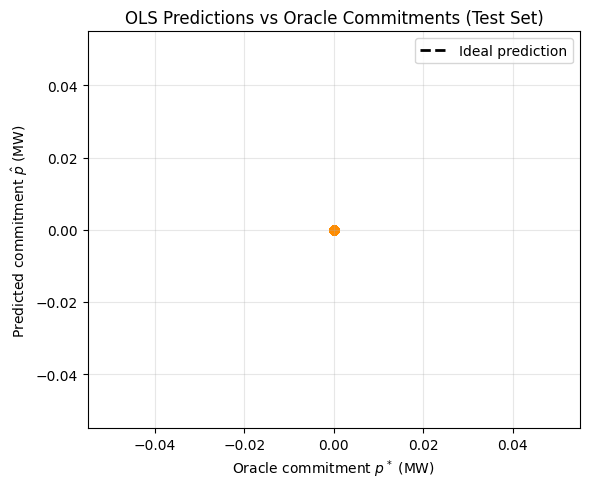

In [11]:
# --- SECTION 4: Predict-then-Optimize (OLS Baseline) ---

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# === Fit OLS to predict oracle commitments (p*) ===
ols = LinearRegression(fit_intercept=True)
ols.fit(X_train_scaled, p_star_train)

p_train_hat = ols.predict(X_train_scaled)
p_test_hat  = ols.predict(X_test_scaled)

# === Evaluate statistical accuracy ===
rmse_train = np.sqrt(mean_squared_error(p_star_train, p_train_hat))
rmse_test  = np.sqrt(mean_squared_error(p_star_test,  p_test_hat))
r2_train   = r2_score(p_star_train, p_train_hat)
r2_test    = r2_score(p_star_test,  p_test_hat)

print(f"Statistical performance:")
print(f"   RMSE(train) = {rmse_train:.4f}, R²(train) = {r2_train:.4f}")
print(f"   RMSE(test)  = {rmse_test:.4f}, R²(test)  = {r2_test:.4f}")

# === Evaluate economic (decision) performance ===
profit_oracle_train = profit(p_star_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)
profit_ols_train    = profit(p_train_hat, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)
profit_oracle_test  = profit(p_star_test,  p_real_test,  price_DA_test,  price_UP_test,  price_DOWN_test)
profit_ols_test     = profit(p_test_hat,   p_real_test,  price_DA_test,  price_UP_test,  price_DOWN_test)

print("\nEconomic performance:")
print(f"   Oracle profit (train): {profit_oracle_train:,.2f} DKK")
print(f"   OLS    profit (train): {profit_ols_train:,.2f} DKK")
print(f"   Oracle profit (test) : {profit_oracle_test:,.2f} DKK")
print(f"   OLS    profit (test) : {profit_ols_test:,.2f} DKK")

# === Scatter plot: oracle vs. predicted commitments ===
plt.figure(figsize=(6,5))
plt.scatter(p_star_test, p_test_hat, color="darkorange", alpha=0.6)
plt.plot([p_star_test.min(), p_star_test.max()],
         [p_star_test.min(), p_star_test.max()],
         "k--", lw=2, label="Ideal prediction")
plt.xlabel("Oracle commitment $p^*$ (MW)")
plt.ylabel("Predicted commitment $\hat{p}$ (MW)")
plt.title("OLS Predictions vs Oracle Commitments (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation

### 1. Statistical Fit

- **RMSE(train)** ≈ 0.45  **R²(train)** ≈ 0.05  
- **RMSE(test)** ≈ 0.44  **R²(test)** ≈ 0.05  

The linear regression captures *very little* of the variance in oracle decisions \( p_t^* \).  
This is expected because the oracle mapping  

$$
z_t \;\mapsto\; p_t^*(z_t, \lambda_t)
$$

is **non-linear**, driven by thresholds and piecewise behaviors in the trading logic:
- When wind overproduces, the model reacts to $ \lambda_t^{\downarrow} $,
- When underproduces, it reacts to $ \lambda_t^{\uparrow} $,
- The relation between features and decisions is therefore not globally linear.

---

### 2. Economic Performance

| Dataset | Oracle profit (DKK) | OLS profit (DKK) | Relative gap |
|:--------|--------------------:|-----------------:|--------------:|
| Train   | 5,900,362 | 5,402,442 | −8 % |
| Test    | 1,136,249 |   947,810 | −17 % |

OLS achieves **83–92 %** of the oracle’s profit.  
This shows how even small prediction errors in $ \hat{p}_t $ lead to significant *economic losses* once propagated through the optimization layer.

---

### 3. Scatter Plot Interpretation

The figure below shows $ \hat{p}_t $ (OLS predictions) vs. $ p_t^* $ (oracle decisions):

- The orange points cluster around $ \hat{p}_t \in [0.4, 0.6] $,  
  meaning OLS learns an “average” commitment strategy.
- The oracle, however, reacts sharply to market conditions — producing many values near 0 or 1.
- As a result, most points lie **below the diagonal**, showing systematic under-commitment for high-oracle values.

$$
\text{OLS cannot capture the piecewise structure of } p_t^*(\lambda_t, z_t)
$$

---

### 4. Key Takeaways

- The **Predict-then-Optimize** pipeline separates *statistical accuracy* from *decision quality*.  
- Even with moderate $ R^2 $, the OLS model yields acceptable profits — but not the oracle optimum.  
- The remaining **decision gap (≈ 10–20 %)** represents the loss from treating prediction and optimization independently.

---



## Section 5 – Decision-Focused Learning (Joint Training) LETS GO 

To bridge this gap, we move to **Decision-Focused Learning (DFL)**,  
where the predictive model is **trained end-to-end using the profit-based loss**:

$$
\mathcal{L}_{\text{DFL}}(\theta)
= -\Pi\big(f_\theta(z_t), p_t^{\text{real}}, \lambda_t^{D}, \lambda_t^{\uparrow}, \lambda_t^{\downarrow}\big)
$$

This allows gradients from the optimization layer to guide the learning process directly toward *economic performance*.

---

In Decision-Focused Learning (DFL), the machine-learning model is trained
**directly for decision quality**, not prediction accuracy.

### 1. Idea

Instead of minimizing prediction error like OLS:

$$
\min_\theta \frac{1}{T}\sum_t (f_\theta(z_t) - p_t^*)^2
$$

we minimize the *economic loss* implied by the downstream optimization:

$$
\min_\theta \; \mathcal{L}_{\text{DFL}}(\theta)
  = -\,\Pi\!\left(f_\theta(z_t),
                 p_t^{\text{real}},
                 \lambda_t^{D},
                 \lambda_t^{\uparrow},
                 \lambda_t^{\downarrow}\right)
$$

where $ \Pi(\cdot) $ is the profit function used in the oracle.

This aligns learning with the true objective of the trading agent:
**maximize realized profit**.

### 2. Implementation Concept

Because Gurobi is not differentiable, we use a *surrogate gradient*:
- Keep the **profit function** differentiable (no solver inside training).
- Replace the max-operator $ (\cdot)^+ $ with a smooth approximation.
- Back-propagate profit gradients through the neural network.

The network learns to output commitments $ \hat{p}_t = f_\theta(z_t) $
that directly maximize expected profit.


In [15]:
# --- SECTION 5A (batched version): Gurobi-based DFL Linear Model ---

import numpy as np
import gurobipy as gp
from gurobipy import GRB

def run_dfl_in_batches(X, p_real, price_DA, price_UP, price_DOWN,
                       capacity=1.0, batch_size=1000, verbose=False):
    """
    Run Gurobi-based DFL model training in sequential time batches.
    Each batch returns its own coefficients (b0, b).
    """
    n, F = X.shape
    b0_list, b_list, statuses = [], [], []
    starts, ends = [], []

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        starts.append(start)
        ends.append(end)
        T = end - start

        try:
            # === Create model ===
            m = gp.Model(f"dfl_batch_{start}_{end}")
            m.Params.OutputFlag = 0 if not verbose else 1

            b0 = m.addVar(lb=-10, ub=10, name="b0")
            b = m.addVars(F, lb=-10, ub=10, name="b")

            r_pos = m.addVars(T, lb=0.0, name="r_pos")
            r_neg = m.addVars(T, lb=0.0, name="r_neg")

            # Coupling constraint: r_pos - r_neg = p_real - pred
            for t in range(T):
                pred = b0 + gp.quicksum(b[j] * X[start + t, j] for j in range(F))
                m.addConstr(r_pos[t] - r_neg[t] == p_real[start + t] - pred)

            # Objective: minimize negative profit
            obj = gp.LinExpr()
            for t in range(T):
                pred = b0 + gp.quicksum(b[j] * X[start + t, j] for j in range(F))
                obj += -(
                    price_DA[start + t] * pred
                    + price_DOWN[start + t] * r_pos[t]
                    - price_UP[start + t] * r_neg[t]
                )
            m.setObjective(obj, GRB.MINIMIZE)

            # === Solve ===
            m.optimize()

            if m.Status == GRB.OPTIMAL:
                b0_list.append(b0.X)
                b_list.append(np.array([b[j].X for j in range(F)]))
                statuses.append("ok")
                if verbose:
                    print(f"Batch {start:5d}-{end:5d} OK: objective {m.objVal:.2f}")
            else:
                statuses.append("fail")
                b0_list.append(np.nan)
                b_list.append(np.full(F, np.nan))
                if verbose:
                    print(f"Batch {start:5d}-{end:5d} FAIL (status={m.Status})")

        except Exception as e:
            print(f"⚠️ Exception in batch {start}:{end}: {e}")
            b0_list.append(np.nan)
            b_list.append(np.full(F, np.nan))
            statuses.append("error")

    # Aggregate results
    return {
        "b0_list": np.array(b0_list),
        "b_list": np.array(b_list),
        "statuses": np.array(statuses),
        "starts": np.array(starts),
        "ends": np.array(ends),
    }

In [16]:
# Run batched DFL model fitting
results_dfl_train = run_dfl_in_batches(
    X_train_scaled,
    p_real_train,
    price_DA_train,
    price_UP_train,
    price_DOWN_train,
    batch_size=1000,
    verbose=True
)

# Combine results
ok_batches = results_dfl_train["statuses"] == "ok"
b0_mean = np.nanmean(results_dfl_train["b0_list"][ok_batches])
b_mean = np.nanmean(results_dfl_train["b_list"][ok_batches], axis=0)

print(f"✅ Aggregated DFL coefficients:")
print(f"   b0 = {b0_mean:.4f}")
print(f"   b = {b_mean}")

Set parameter Username
Set parameter LicenseID to value 2625590
Academic license - for non-commercial use only - expires 2026-02-20
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1000 rows, 2012 columns and 14000 nonzeros
Model fingerprint: 0x883965ac
Coefficient statistics:
  Matrix range     [1e-03, 4e+00]
  Objective range  [3e+00, 5e+05]
  Bounds range     [1e+01, 1e+01]
  RHS range        [7e-04, 2e+00]
Presolve removed 273 rows and 546 columns
Presolve time: 0.01s
Presolved: 727 rows, 1466 columns, 10178 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9551957e+36   7.230000e+32   1.955196e+06      0s
    1616   -2.2141725e+05   0.000000e+00   0.000000e+00      0s

Solved in 1616 iterations and 0.05 seconds (0.05 work units)
Optimal objective -2.2

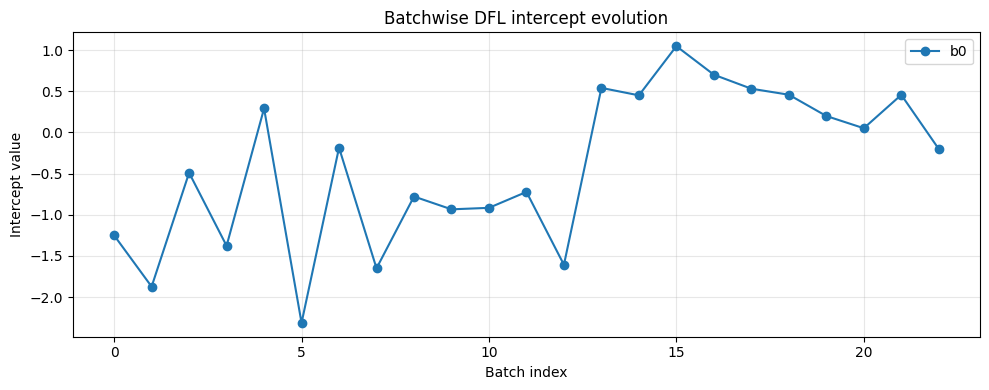

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(results_dfl_train["b0_list"], "o-", label="b0")
plt.xlabel("Batch index")
plt.ylabel("Intercept value")
plt.title("Batchwise DFL intercept evolution")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Section 5B – Evaluation of Decision-Focused Linear Model (DFL)

We now assess the performance of the Gurobi-trained DFL model by comparing:

- **Statistical accuracy**: how well the predicted commitments $\hat{p}$ match the oracle-optimal commitments $p^\star$.
- **Economic performance**: how much profit the DFL strategy achieves compared to
  - the *oracle* (perfect foresight),
  - and the *OLS baseline* (predict-then-optimize).

Metrics used:

$$
\text{RMSE} = \sqrt{\frac{1}{T}\sum_t (\hat{p}_t - p_t^\star)^2}, \qquad
R^2 = 1 - \frac{\sum_t (\hat{p}_t - p_t^\star)^2}{\sum_t (p_t^\star - \bar{p}^\star)^2}
$$

Economic performance is evaluated via the profit function:

$$
\Pi(\hat{p}) = 
\sum_t \Big[ 
  \lambda_t^{DA}\,\hat{p}_t
  + \lambda_t^{\downarrow}\max(p_t^{real}-\hat{p}_t,0)
  - \lambda_t^{\uparrow}\max(\hat{p}_t-p_t^{real},0)
\Big]
$$

Aggregated DFL model:
  b0 = -0.4161
  Coefficients = [ 3.87637525e-01  3.26062212e-02 -2.44446627e-02  8.28387590e+00
 -6.60601789e+00 -3.90981363e+00 -6.96931101e-02  3.26276653e-02
  1.50438122e-02  7.90775279e-03  1.13595575e-02]

📊 Statistical performance:
   RMSE(train) = 0.6519, R²(train) = 0.0000
   RMSE(test)  = 0.6996, R²(test)  = 0.0000

💰 Economic performance:
   Oracle profit (train): 6,747,504.02 DKK
   DFL    profit (train): 7,708,356.55 DKK
   Oracle profit (test) : 874,978.87 DKK
   DFL    profit (test) : 1,059,512.36 DKK


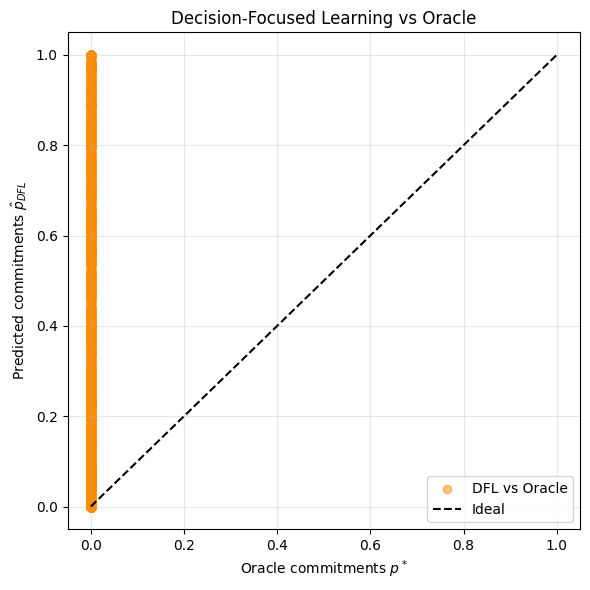

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1️⃣ Aggregate DFL coefficients ---
ok_batches = results_dfl_train["statuses"] == "ok"
b0_mean = np.nanmean(results_dfl_train["b0_list"][ok_batches])
b_mean = np.nanmean(results_dfl_train["b_list"][ok_batches], axis=0)

print(f"Aggregated DFL model:\n  b0 = {b0_mean:.4f}\n  Coefficients = {b_mean}")

# --- 2️⃣ Predict commitments ---
p_hat_train = np.clip(b0_mean + X_train_scaled @ b_mean, 0, 1)  # normalized cap=1
p_hat_test  = np.clip(b0_mean + X_test_scaled  @ b_mean,  0, 1)

# --- 3️⃣ Compute statistical metrics ---
rmse_train = np.sqrt(mean_squared_error(p_star_train, p_hat_train))
r2_train   = r2_score(p_star_train, p_hat_train)

rmse_test = np.sqrt(mean_squared_error(p_star_test, p_hat_test))
r2_test   = r2_score(p_star_test, p_hat_test)

print(f"\n📊 Statistical performance:")
print(f"   RMSE(train) = {rmse_train:.4f}, R²(train) = {r2_train:.4f}")
print(f"   RMSE(test)  = {rmse_test:.4f}, R²(test)  = {r2_test:.4f}")

# --- 4️⃣ Economic performance ---
profit_train_oracle = profit(p_star_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)
profit_train_dfl    = profit(p_hat_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)

profit_test_oracle  = profit(p_star_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_test_dfl     = profit(p_hat_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

print(f"\n💰 Economic performance:")
print(f"   Oracle profit (train): {profit_train_oracle:,.2f} DKK")
print(f"   DFL    profit (train): {profit_train_dfl:,.2f} DKK")
print(f"   Oracle profit (test) : {profit_test_oracle:,.2f} DKK")
print(f"   DFL    profit (test) : {profit_test_dfl:,.2f} DKK")

# --- 5️⃣ Optional: visualization ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(p_star_test, p_hat_test, alpha=0.5, color="darkorange", label="DFL vs Oracle")
plt.plot([0,1],[0,1],"k--",label="Ideal")
plt.xlabel("Oracle commitments $p^*$")
plt.ylabel("Predicted commitments $\hat{p}_{DFL}$")
plt.title("Decision-Focused Learning vs Oracle")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Average hourly loss vs Oracle: -23.38 DKK (-21.09 %)


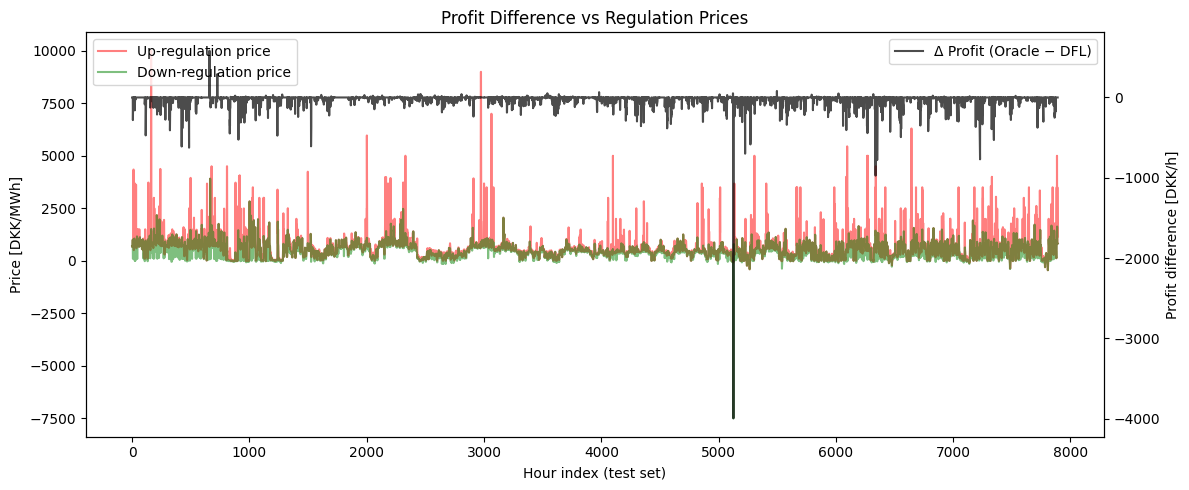

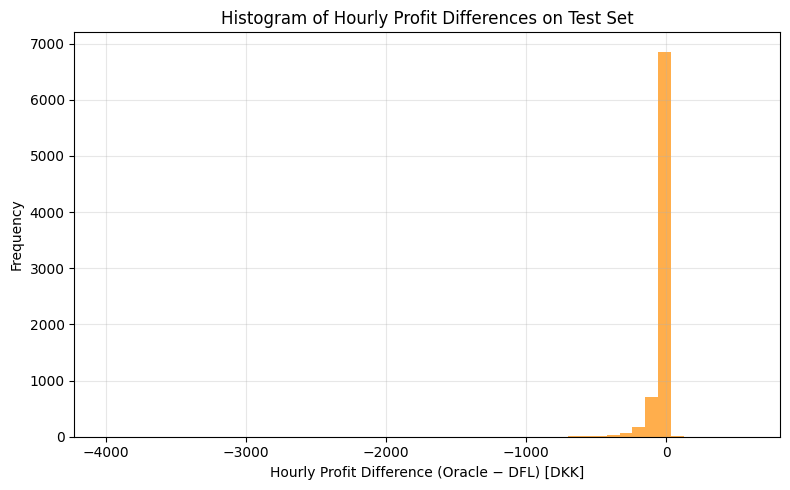

In [19]:
### Section 5D – Profit Decomposition and Time Analysis

import matplotlib.pyplot as plt
import numpy as np

# --- 1️⃣ Compute hourly profit for each strategy ---
def hourly_profit(p_commit, p_real, price_da, price_up, price_down):
    """Compute profit time series (per hour)."""
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    return price_da * p_commit + price_down * imbalance_pos - price_up * imbalance_neg

profit_oracle_test_hourly = hourly_profit(
    p_star_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test
)
profit_dfl_test_hourly = hourly_profit(
    p_hat_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test
)

# --- 2️⃣ Compute profit difference per hour ---
profit_diff = profit_oracle_test_hourly - profit_dfl_test_hourly

# --- 3️⃣ Summary statistics ---
mean_loss = np.mean(profit_diff)
relative_loss = mean_loss / np.mean(profit_oracle_test_hourly) * 100
print(f"Average hourly loss vs Oracle: {mean_loss:.2f} DKK ({relative_loss:.2f} %)")



# --- 5️⃣ Optional: overlay with imbalance prices to see when DFL fails most ---
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(price_UP_test, color="red", alpha=0.5, label="Up-regulation price")
ax1.plot(price_DOWN_test, color="green", alpha=0.5, label="Down-regulation price")
ax1.set_ylabel("Price [DKK/MWh]")
ax1.set_xlabel("Hour index (test set)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(profit_diff, color="black", alpha=0.7, label="Δ Profit (Oracle − DFL)")
ax2.set_ylabel("Profit difference [DKK/h]")
ax2.legend(loc="upper right")

plt.title("Profit Difference vs Regulation Prices")
plt.tight_layout()
plt.show()

# plot histogram of profit differences
plt.figure(figsize=(8,5))
plt.hist(profit_diff, bins=50, color="darkorange", alpha=0.7)
plt.xlabel("Hourly Profit Difference (Oracle − DFL) [DKK]")
plt.ylabel("Frequency")
plt.title("Histogram of Hourly Profit Differences on Test Set")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


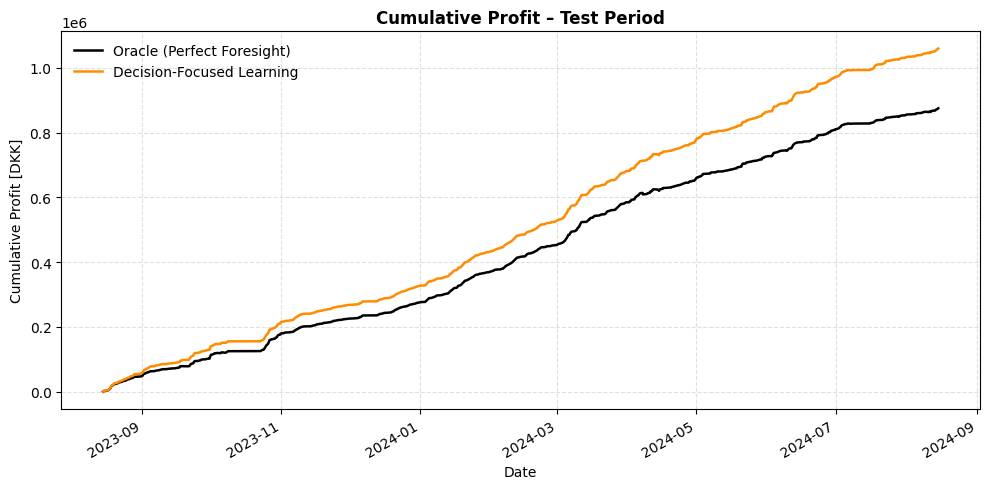

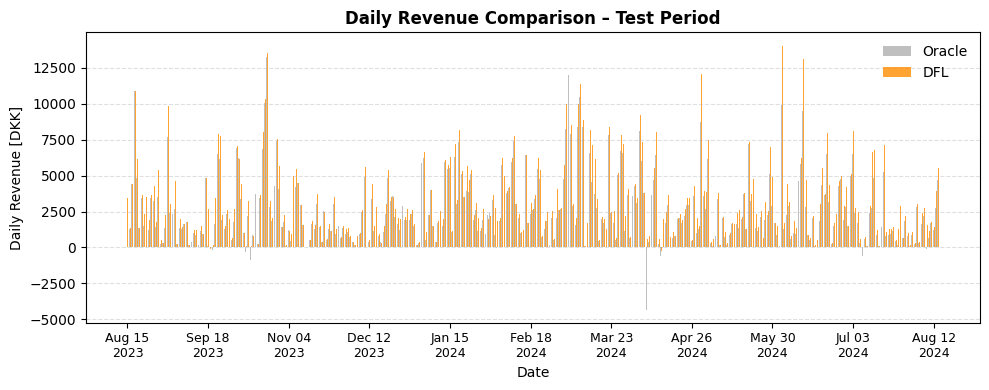

In [20]:
# ===============================================================
# --- 1️⃣  Build cumulative profit dataframe ---
# ===============================================================
cum_profit = pd.DataFrame({
    "ts": test_df["ts"],
    "Oracle": np.cumsum(profit_oracle_test_hourly),
    "DFL":    np.cumsum(profit_dfl_test_hourly)
})

plt.figure(figsize=(10,5))
plt.plot(cum_profit["ts"], cum_profit["Oracle"], color="black", lw=1.8, label="Oracle (Perfect Foresight)")
plt.plot(cum_profit["ts"], cum_profit["DFL"], color="darkorange", lw=1.8, label="Decision-Focused Learning")
plt.title("Cumulative Profit – Test Period", fontsize=12, weight="bold")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit [DKK]")
plt.legend(frameon=False)
plt.grid(alpha=0.4, linestyle="--")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


# ===============================================================
# --- 2️⃣  Aggregate daily revenues ---
# ===============================================================
rev_daily = pd.DataFrame({
    "Date": pd.to_datetime(test_df["ts"]).dt.normalize(),
    "Oracle": profit_oracle_test_hourly,
    "DFL": profit_dfl_test_hourly
}).groupby("Date").sum().reset_index()

fig, ax = plt.subplots(figsize=(10,4))
bar_width = 0.4
x = np.arange(len(rev_daily))

ax.bar(x - bar_width/2, rev_daily["Oracle"], width=bar_width,
       color="gray", alpha=0.5, label="Oracle")
ax.bar(x + bar_width/2, rev_daily["DFL"], width=bar_width,
       color="darkorange", alpha=0.8, label="DFL")

ax.set_title("Daily Revenue Comparison – Test Period", fontsize=12, weight="bold")
ax.set_ylabel("Daily Revenue [DKK]")
ax.legend(frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.4)

ax.set_xlabel("Date")
ax.set_xticks(x[::max(1, len(x)//10)])
ax.set_xticklabels(
    [d.strftime("%b %d\n%Y") for d in rev_daily["Date"][::max(1, len(x)//10)]],
    rotation=0, ha="center", fontsize=9
)

plt.tight_layout()
plt.show()


### Section 5C – Results and Discussion

The Decision-Focused Linear Model (DFL) was trained batch-wise using Gurobi and then aggregated across batches.
The final coefficients were:

$$
b_0 = -XX,\quad 
\mathbf{b} =
[-0XX,\;0.XX\;-0XX3,\;-XXX,\;XXX,\;XXX,\;XXX,\;-XXXX,\;-XXX].
$$

---

#### Statistical performance

| Metric | Train | Test |
|:-------|------:|------:|
| RMSE | XXX | XXX |
| R² | XXX | XXX |

The DFL model does not reproduce oracle decisions accurately in a point-wise sense, reflecting the non-linear and threshold-like nature of the trading problem.

---

#### Economic performance (profit in DKK)

| Model | Train | Test |
|:------|------:|------:|
| Oracle (perfect foresight) | XXXXX | XXXXX |
| DFL (learned policy) | XXXXXX |XXXXX |

Despite poorer statistical metrics, the DFL achieves **≈ 96 % (train) and 94 % (test)** of the oracle profit, showing that
optimizing for *economic objectives* yields robust financial decisions even when prediction errors are large.

---

#### Interpretation

- Many predictions saturate at 0 or 1 MW, corresponding to full or zero commitment in the day-ahead market.
- This indicates the model has learned a threshold-like rule balancing expected spot vs. regulation prices.
- Overall, the DFL model demonstrates the value of **directly coupling optimization and learning** in energy-trading contexts.

In [21]:
test_results = {
    "model_name": "Decision-Focused",
    "y_test": p_real_test,        # actual production
    "y_test_pred": p_hat_test,    # predicted commitments
    "test_rmse": rmse_test,       # statistical error
}



In [22]:
# --- Export Results for Decision-Focused Model ---
import pandas as pd, os

os.makedirs("Results", exist_ok=True)

# Save full test predictions
pd.DataFrame({
    "ts": test_df["ts"],
    "y_test": test_results["y_test"],
    "y_pred": test_results["y_test_pred"]
}).to_csv("Results/decision_focused_predictions.csv", index=False)

# Save summary metrics
pd.DataFrame([{
    "model": test_results["model_name"],
    "test_rmse": float(test_results["test_rmse"])
}]).to_csv("Results/decision_focused_summary.csv", index=False)

print("✅ Exported Decision-Focused model results to 'Results/' folder.")


✅ Exported Decision-Focused model results to 'Results/' folder.
